In [1]:
from glob import glob
import pickle as pkl
from typing import List

### get data

In [2]:
!ls -lh *.pkl

-rw-r--r-- 1 root root  25K May 30 00:51 answers.pkl
-rw-r--r-- 1 root root 8.1M May 30 00:51 evidences.pkl
-rw-r--r-- 1 root root 238K May 30 00:51 predictions.pkl
-rw-r--r-- 1 root root  14K May 30 00:51 qids.pkl
-rw-r--r-- 1 root root    4 May 30 00:51 q_tokens.pkl
-rw-r--r-- 1 root root  42K May 30 00:51 questions.pkl
-rw-r--r-- 1 root root  95K May 30 00:51 scores.pkl
-rw-r--r-- 1 root root 347K May 30 00:51 titles.pkl


In [3]:
vals = {
    f.split('.pkl')[0]: pkl.load(open(f, 'rb'))
    for f in glob('*.pkl')
    if 'q_tokens' not in f  # this is empty
}
iters = ['answers', 'scores', 'titles', 'predictions', 'evidences']
vals.keys()

dict_keys(['questions', 'answers', 'scores', 'titles', 'qids', 'predictions', 'evidences'])

### evidence <=> paragraph

In [4]:
vals['evidences'][0][0]

'Today\'s autodialer supposedly runs a smarter software, claiming a less than 2% hangup rate. However, most telemarketing companies place thousands of calls an hour, bringing that 2% back up to an annoying level. Ray Bradbury wrote a story, "Number of the ghost - 777888999", about a telephone switch box that gained sentience. Its first order of business in the world, stalking. Eventually the person documenting the calls traced it down to a specific phone box and was summarily executed by said box through electrocution.'

### sanity check: predictions are extracted from the "evidence"

In [12]:
vals['predictions'][0]

['electrocution.',
 'nasal fracture',
 'spasmodic dysphonia.',
 'exaggerated jaw vibrato"',
 'straining his vocal cords',
 'kidney failure',
 'Botox shots',
 'weak',
 'drugs',
 'a bizarre accident',
 'A middle ear infection',
 'falling from a ladder',
 'scarlet fever and measles.',
 'throat cancer surgery',
 'digitally erased',
 'abductor spasmodic dysphonia,']

In [5]:
vals['predictions'][0][0]

'electrocution.'

In [6]:
assert all(
    p in e
    for es, ps in zip(vals['evidences'], vals['predictions'])
    for e, p in zip(es, ps)
)

### sanity check: make sure things are the same length

In [7]:
assert all(
    len(s) == len(e) == len(p) == len(t)
    for s, e, p, t in zip(
        vals['scores'],
        vals['evidences'],
        vals['predictions'],
        vals['titles'],
    )
)

### sanity check: all scores are sorted

In [8]:
assert all(
    s == sorted(s, reverse=True)
    for s in vals['scores']
)

### success @ k

In [9]:
def success_at_k_one(answers: List[str], evidences: List[str], k: int) -> bool:
    """
    for a single instance.
    
    any of the answers is found in the top k evidence / paragraph
    this assumes that the evidence is in the same sorted order as `scores`
    """

    return any(
        a in e
        for a in answers
        for e in evidences[:k]
    )

def success_at_k(answers: List[List[int]], evidences: List[List[str]], k: int) -> float:
    """
    for a collection. just count the fraction of success@k's.
    """
    n = len(answers)
    return sum(
        success_at_k_one(a, e, k)
        for a, e in zip(answers, evidences)
    ) / n

### compute for different values of `k`

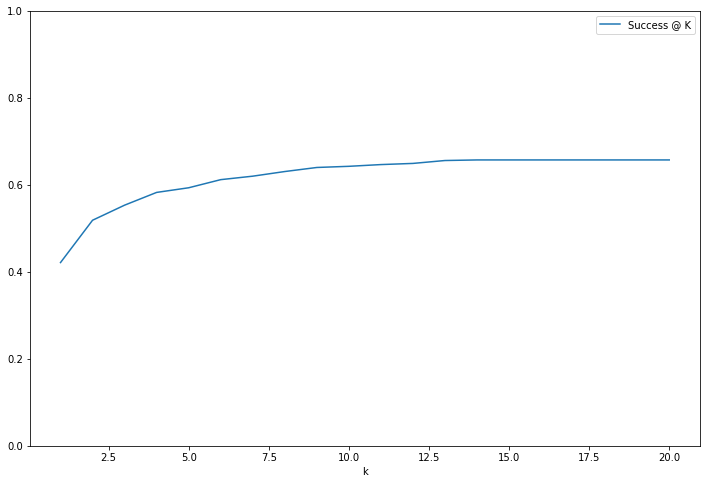

In [10]:
df = pd.DataFrame(
    {
        "k": k,
        "Success @ K": success_at_k(
            vals['answers'],
            vals['evidences'],
            k,
        ),
    }
    for k in range(1, 20 + 1)
).set_index('k')
df.plot(figsize=(12, 8))
_ = plt.ylim([0, 1])

In [11]:
df

,Success @ K
k,
1,0.421333
2,0.518667
3,0.553333
4,0.582667
5,0.593333
6,0.612000
7,0.620000
8,0.630667
9,0.640000
